# AUK

This notebook is used to calculate and plot the AUK and kappa curves for a single combination so that I can use it as an example in the thesis report. In short:
- Calculate class seperation for all *r* values, meaning all unique prediction values made by the model for the test set that are used as boundary value.
- Highest kappa value is then used to determine the best seperating threshold

Then when the best seperating threshold is found, the performance is calculated on that specific threshold.

### General functions and imports

In [27]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import os
from glob import glob
from other_lib.general_functions import prepare_dataset_for_model, image_encoder_cv
from other_lib.model_builder import create_transformer_from_h5
from other_lib import globalvar
from other_lib.auk_score import AUK
from tensorflow.keras import models, backend, regularizers
from ast import literal_eval

import plotly.express as px

def find_all_csv_locations_auk():
    # make a list of all csv files
    data_folder = 'C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\encoded_logs\\' #define folder where all encoded logs are stored
    file_extension = '*.csv' #define file extension
    all_csv_files = [] #store csv files in this list
    for path, subdir, files in os.walk(data_folder):
        for file in glob(os.path.join(path, file_extension)):
            all_csv_files.append(file)

    #calculate files that are skipped for now to save time
    skip_files = [] 
    filter_list = ['max', '16', '32', '64', 'random', 'test', 'train', 'outcome', 'aggregated', 'los']
    for file in all_csv_files:
        for filter_val in filter_list:
            if filter_val in file.lower():
                skip_files.append(file)
    file_locations = [file for file in all_csv_files if file not in skip_files] #keep only the csv files that are not to be skipped
    
    return file_locations

def find_hyperparams(param_dir, dataset):
    for file in os.listdir(param_dir):
        if file.endswith('.txt') and file.startswith(dataset):
            with open(param_dir + file, 'r') as file: #get hyperparameters of best model
                param_dict = literal_eval(file.read())
                file.close()
                return param_dict

In [ ]:
#Function that calculates the performance of each model at the optimal seperating threshold (calculated with AUK)
def calc_optimal_scores()
    model_names = ['orange', 'di_mauro_cnn', 'galanti_lstm', 'transformer']
    model_types = ['cnn', 'cnn' ,'lstm' , 'transformer']
    file_locations = find_all_csv_locations_auk()
    name_list, type_list, dataset_list, fscore_list, precision_list, recall_list, threshold_list = [], [], [], [], [], [], []

    for file_loc in file_locations:
        for model_name, model_type in zip(model_names, model_types):
            dataset = file_loc.split("\\")[-1:][0].split('.')[0] #get filename (without.csv)

            #prepare data
            x_train, x_val, x_test, y_train, y_val, y_test, binary, X, y, model_type = prepare_dataset_for_model(file_loc, model_type)

            #first load the original best model for the perticular dataset
            if model_name == 'transformer':
                param_dict = find_hyperparams('C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\transformer\\results\\hyperparameters\\', dataset)
                original_model, x_train, x_test = create_transformer_from_h5(x_train, x_test, y_train, y_test, binary, dataset, param_dict) #rebuild the model using the hyperparameters
                original_model.load_weights('C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\transformer\\models\\' + dataset + '_model-weights.h5') #load model weights
                y_pred = original_model.predict(x_test)
            elif model_name == 'orange': 
                x_train, x_test = image_encoder_cv(x_train, x_test, y_train, y_test)#encode the training/testing data to pixel values
                model_loc = 'C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\' + model_name + '\\models\\' + dataset + '.h5'
                original_model = models.load_model(model_loc, custom_objects={'f1': globalvar.f1, 'precision': globalvar.precision, 'recall': globalvar.recall, 'auc': globalvar.auc})
                y_pred = original_model.predict(x_test)
            else:
                model_loc = 'C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\' + model_name + '\\models\\' + dataset + '.h5'
                original_model = models.load_model(model_loc, custom_objects={'f1': globalvar.f1, 'precision': globalvar.precision, 'recall': globalvar.recall, 'auc': globalvar.auc})
                y_pred = original_model.predict(x_test)

            #calculate the kappa, fpr and tpr values
            kappa_vals = AUK(y_test, y_pred.flatten()).kappa_curve()
            fpr_vals = AUK(y_test, y_pred.flatten()).fpr_curve()
            tpr_vals = AUK(y_test, y_pred.flatten()).tpr_curve()

            kappa_index = np.argmax(kappa_vals) #get index of highest kappa value
            best_fpr = fpr_vals[kappa_index] #calculate fpr at highest kappa value
            best_tpr = tpr_vals[kappa_index] #calculate tpr at highest kappa value

            best_threshold = best_tpr - best_fpr #determine best threshold according to youden index (tpr - fpr)
            y_pred_threshold = np.where(y_pred > best_threshold, 1, 0)[:, 0] #classify predictions according to new best threshold

            #change datatype to float as the metrics don't work with ints
            y_test = y_test.astype('float64')
            y_pred_threshold = y_pred_threshold.astype('float64')

            #calculate performance of best seperating threshold according to kappa score
            recall = round(globalvar.recall(y_test, y_pred_threshold).numpy(), 4)
            precision = round(globalvar.precision(y_test, y_pred_threshold).numpy(), 4)
            fscore = round(globalvar.f1(y_test, y_pred_threshold).numpy(), 4)

            #append scores to lists
            name_list.append(model_name)
            type_list.append(model_type)
            dataset_list.append(dataset)
            fscore_list.append(fscore)
            precision_list.append(precision)
            recall_list.append(recall)
            threshold_list.append(best_threshold)

    #create dictionary of score lists
    auk_results_dict = {'names': name_list,
                'types': type_list,
                'datasets': dataset_list,
                'fscores': fscore_list,
                'precisions': precision_list,
                'recalls': recall_list,
                'thresholds': threshold_list}

    return pd.DataFrame(auk_results_dict)


## Calculate the values of a single combination
combination is determined through model_name and file_list (encoded file location)

In [114]:
model_names = ['di_mauro_cnn']
model_types = ['cnn']
file_list = ['C:\\Users\\20190337\\Downloads\\Tracebook_v2 (Projectfolder)\\encoded_logs\\word2vec\\average\\8\\EventLog_Processed_Paracetamol_8_word2vec_avg_additional.csv']
name_list, type_list, dataset_list, fscore_list, precision_list, recall_list, threshold_list = [], [], [], [], [], [], []

for file_loc in file_list:
    for model_name, model_type in zip(model_names, model_types):
        dataset = file_loc.split("\\")[-1:][0].split('.')[0] #get filename (without.csv)
        #print('now starting: ', dataset, ' with model_name: ', model_name)

        #prepare data
        x_train, x_val, x_test, y_train, y_val, y_test, binary, X, y, model_type = prepare_dataset_for_model(file_loc, model_type)

        #first load the original best model for the perticular dataset
        if model_name == 'transformer':
            param_dict = find_hyperparams('C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\transformer\\results\\hyperparameters\\', dataset)
            original_model, x_train, x_test = create_transformer_from_h5(x_train, x_test, y_train, y_test, binary, dataset, param_dict) #rebuild the model using the hyperparameters
            original_model.load_weights('C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\transformer\\models\\' + dataset + '_model-weights.h5') #load model weights
            y_pred = original_model.predict(x_test)
        elif model_name == 'orange': 
            x_train, x_test = image_encoder_cv(x_train, x_test, y_train, y_test)#encode the training/testing data to pixel values
            model_loc = 'C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\' + model_name + '\\models\\' + dataset + '.h5'
            original_model = models.load_model(model_loc, custom_objects={'f1': globalvar.f1, 'precision': globalvar.precision, 'recall': globalvar.recall, 'auc': globalvar.auc})
            y_pred = original_model.predict(x_test)
        else:
            model_loc = 'C:\\Users\\20190337\\Downloads\Tracebook_v2 (Projectfolder)\\model_results\\' + model_name + '\\models\\' + dataset + '.h5'
            original_model = models.load_model(model_loc, custom_objects={'f1': globalvar.f1, 'precision': globalvar.precision, 'recall': globalvar.recall, 'auc': globalvar.auc})
            y_pred = original_model.predict(x_test)

        #calculate the kappa, fpr and tpr values
        kappa_vals = AUK(y_test, y_pred.flatten()).kappa_curve()
        fpr_vals = AUK(y_test, y_pred.flatten()).fpr_curve()
        tpr_vals = AUK(y_test, y_pred.flatten()).tpr_curve()

        kappa_index = np.argmax(kappa_vals) #get index of highest kappa value
        best_fpr = fpr_vals[kappa_index] #calculate fpr at highest kappa value
        best_tpr = tpr_vals[kappa_index] #calculate tpr at highest kappa value

        best_threshold = best_tpr - best_fpr #determine best threshold according to youden index (tpr - fpr)
        y_pred_threshold = np.where(y_pred > best_threshold, 1, 0)[:, 0] #classify predictions according to new best threshold

        #change datatype to float as the metrics don't work with ints
        y_test = y_test.astype('float64')
        y_pred_threshold = y_pred_threshold.astype('float64')

        #calculate performance of best seperating threshold according to kappa score
        recall = round(globalvar.recall(y_test, y_pred_threshold).numpy(), 4)
        precision = round(globalvar.precision(y_test, y_pred_threshold).numpy(), 4)
        fscore = round(globalvar.f1(y_test, y_pred_threshold).numpy(), 4)
        
print('scores for: ', dataset, ' using model: ', model_name)
print('predictions: ', np.where(y_pred > best_threshold, 1, 0)[:, 0])
print('recall: ', recall)
print('precision: ', precision)
print('fscore: ', fscore)

C:\Users\20190337\My Drive\JADS\Thesis - New\Notebooks\Experiments\other_lib\general_functions.py:32: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



scores for:  EventLog_Processed_Paracetamol_8_word2vec_avg_additional  using model:  di_mauro_cnn
predictions:  [1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1]
recall:  0.9857
precision:  0.6273
fscore:  0.7667


# Plotting example figure

Below, the single example of the kappa curve and AUC curve is plotted which I used as an example  in the thesis

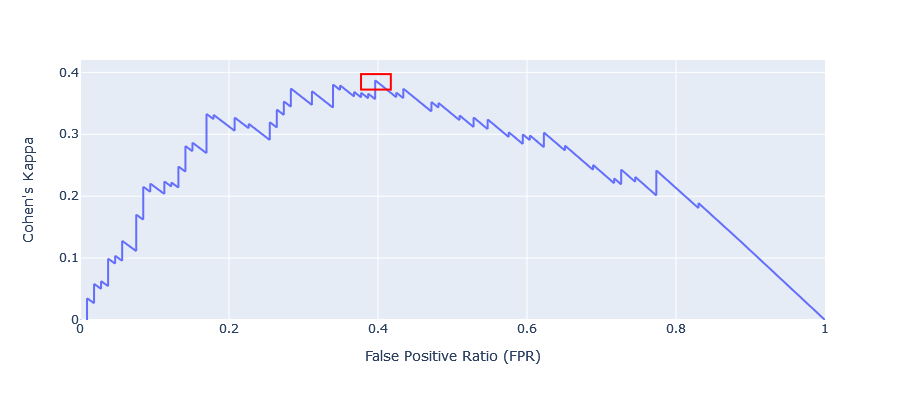

91
0.38722445915512194
0.39622641509433965


In [174]:
d = {'kappa_vals': kappa_vals, 'fpr_vals': fpr_vals, 'tpr_vals': tpr_vals}
df = pd.DataFrame(data=d)
highest_kappa = kappa_vals[kappa_index]

fig = px.line(df, x="fpr_vals", y="kappa_vals")
fig.update_layout(width=500, height=400)
fig.update_yaxes(range=[0, 0.42], title="Cohen's Kappa")
fig.update_xaxes(range=[0, 1], title='False Positive Ratio (FPR)')


fig.add_shape(editable=True,
              x0=highest_kappa-0.01, x1=highest_kappa+0.03, y0=highest_kappa-0.015, y1=highest_kappa+0.01,
              xref='x', yref='y', line_color='red')

fig.show()

print(kappa_index)
print(kappa_vals[kappa_index])
print(fpr_vals[kappa_index])

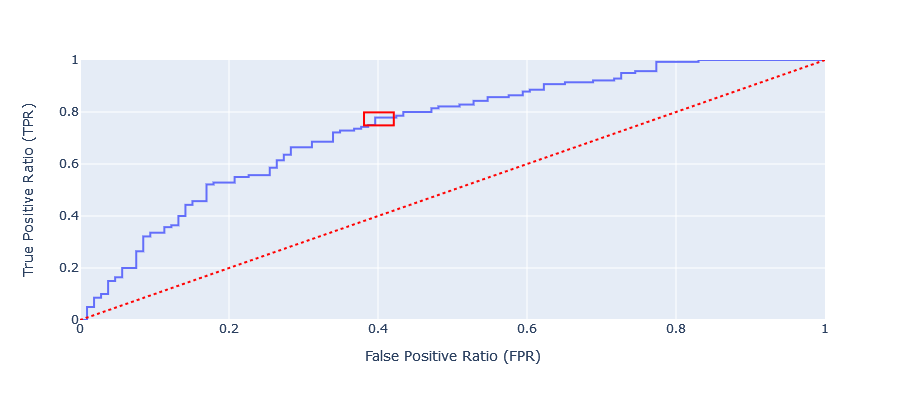

91
0.39622641509433965
0.7785714285714286


In [175]:
d = {'kappa_vals': kappa_vals, 'fpr_vals': fpr_vals, 'tpr_vals': tpr_vals}
df = pd.DataFrame(data=d)
opt_fpr = tpr_vals[kappa_index]
opt_tpr = fpr_vals[kappa_index]

fig = px.line(df, x="fpr_vals", y="tpr_vals")
fig.update_layout(width=500, height=400)
fig.update_yaxes(range=[0, 1], title="True Positive Ratio (TPR)")
fig.update_xaxes(range=[0, 1], title='False Positive Ratio (FPR)')
fig.add_shape(type="line",
              x0=0, y0=0, x1=1, y1=1,
              line=dict(color="red", width=2, dash="dot"))
fig.add_shape(editable=True,
              x0=opt_tpr-0.015, x1=opt_tpr+0.025, y0=opt_fpr-0.03, y1=opt_fpr+0.02,
              xref='x', yref='y', line_color='red')

fig.show()

print(kappa_index)
print(fpr_vals[kappa_index])
print(tpr_vals[kappa_index])

In [176]:
tpr_vals[kappa_index] - fpr_vals[kappa_index]

0.38234501347708894